In [1]:
import sqlite3
from sqlite3 import Error
import os.path
from os import path

#from create_db import create_connection, create_table, clean_column_names
#from populate_db import extract_data, insert_records
#import query_db as qd
import config
import build_dataset as build
import pipeline
import classification

import importlib
import datetime
import re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

In [21]:
importlib.reload(build)
importlib.reload(config)
importlib.reload(pipeline)
importlib.reload(classification)

<module 'classification' from '/Users/charmainerunes/git/covid_decarceration/files/classification.py'>

# Notebook table of contents:
1. Run all models for binary outcome variable. Run the best model according to F1 score and precision, predict on test data, calculate evaluation metrics
2. Repeat 1 without using demographic features
3. Repeat 1-2 on three-class outcome variable
4. Repeat 1-2 on 6-class outcome variable

In [3]:
# Import data
dataset_3 = pd.read_csv('../data/dataset_main_active3.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,22,29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Set target
target = config.target_vars[0]

In [22]:
# Step 1
target_type = "binary"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix',
       'Recidivate_Risk_Level', 'age_cat', 'age_first_offense',
       'juv_first_offense', 'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [23]:
#target = config.target_vars[0]
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542,...,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542


In [53]:
# train_backup = train_data.copy()
# validate_backup = validate_data.copy()
# test_backup = test_data.copy()


In [54]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-package

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


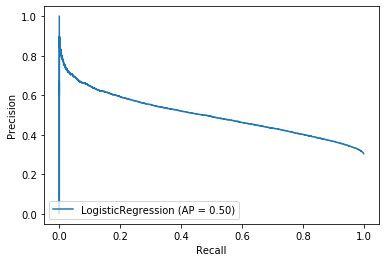

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[68489  4967]
 [25169  6998]]
Accuracy:	0.7146833549510997
Precision:	0.5848725449226911
Recall:		0.21755214971865577
F1 Score:	0.31713949061905194

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, split

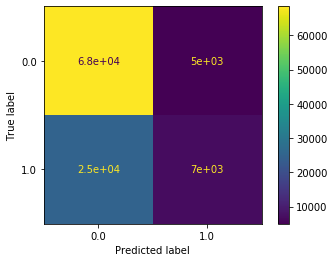

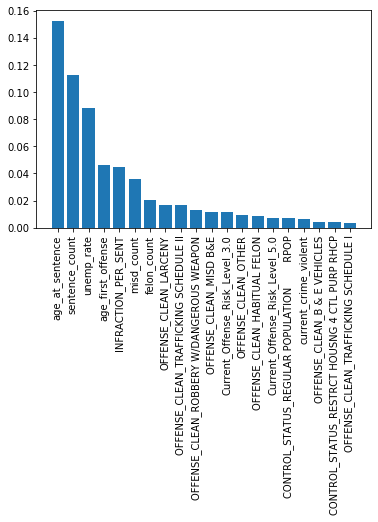

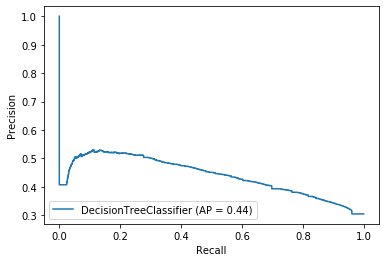

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[64903  8553]
 [23255  8912]]
Accuracy:	0.6988534694148055
Precision:	0.5102776982536501
Recall:		0.2770541237914633
F1 Score:	0.3591231463571889

Time Elapsed: 0:07:51.180058


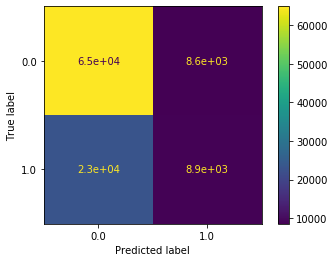

In [24]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)

best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)

In [25]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",2,1,1,1,0.680379,0.275266,0.587182,0.374743
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",1,2,2,2,0.676688,0.198873,0.608442,0.299619
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.653577,0.309961,0.503609,0.383733
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.671241,0.272547,0.558011,0.365648


In [26]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.714683,0.584873,0.217552,0.317139
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.698853,0.510278,0.277054,0.359123


In [27]:
# Step 2
target_type = "binary"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  31360
Dataset size:  527096


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Total Number of Unique IDs: 304786
Total Number of IDs in Test Data: 60957
Total Number of IDs in Train Data: 195063
Total Number of IDs in Validate Data: 48766
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.19999934380188067
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8000006561981193
Does Validate Represent 20% of the Train+Validate Data?: 0.20000082024697635
Does Train Represent 80% of the Train+Validate Data?: 0.7999991797530236


/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)
/Users/charmainerunes/git/covid_decarceration/files/build_dataset.py:693: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [28]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older,CONTROL_STATUS_OUT OF CELL RESTRICTION OUTC
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575,...,58575,58575,58575,58575,58575,58575,58575,58575,58575,58575
1.0,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542,...,25542,25542,25542,25542,25542,25542,25542,25542,25542,25542


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-package

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


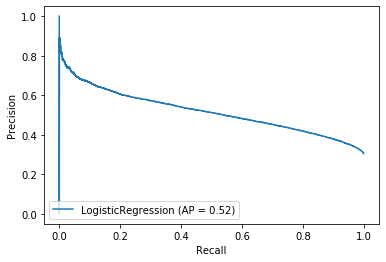

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[67658  5798]
 [23951  8216]]
Accuracy:	0.7183473296535793
Precision:	0.5862708719851577
Recall:		0.2554170423104424
F1 Score:	0.3558173274723371

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, spli

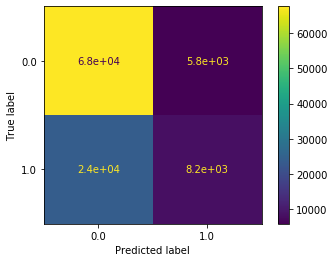

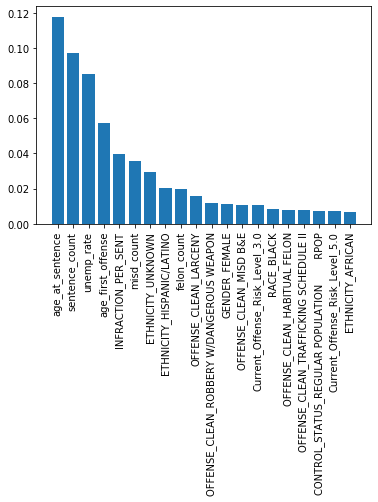

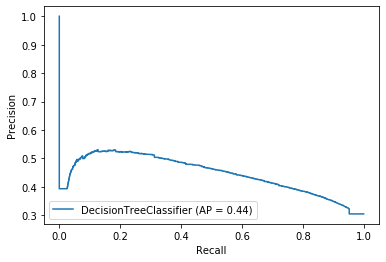

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[63868  9588]
 [22116 10051]]
Accuracy:	0.6998381034433788
Precision:	0.511787769234686
Recall:		0.31246308328411104
F1 Score:	0.3880245531405629

Time Elapsed: 0:09:11.810535


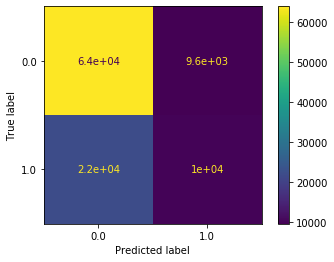

In [29]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)

best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [30]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",2,1,1,1,0.686494,0.340492,0.585806,0.430425
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",1,2,2,2,0.683429,0.257180,0.606659,0.361127
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.657405,0.375206,0.510713,0.432556
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.673376,0.318098,0.554486,0.403419


In [31]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.718347,0.586271,0.255417,0.355817
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.699838,0.511788,0.312463,0.388025


In [ ]:
# Step 3
target_type = "three_class"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 3
target_type = "three_class"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 4
target_type = "all"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 4
target_type = "all"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models